### Case Study

Traders who are particuarly keen on Pairs Trading, need a way to find pairs that:
    
    a) Are similar in risk and behaviour
    b) Are cointegrated

K-Means Clustering is a Clustering technique as to which a vast array of features can have their data compared with one another and grouped into clusters of similarity. The applications of this are vast as described in the theory sections of the course.

Once stocks/cryptocurrencies/FOREX pairs are grouped, they can then have cointegration calculations run against them to further help with statistical methods. Although cointegration is more a statistics method rather than Machine Learning, the code has been included here for convenience.

### Imports

In [98]:
# Remove unwanted warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data extraction and management
import pandas as pd
import numpy as np
import yfinance as yf
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols

# Feature Engineering
from sklearn.preprocessing import StandardScaler

# Machine Learning
from sklearn.cluster import KMeans
from sklearn import metrics
from kneed import KneeLocator

# Cointegration and Statistics
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm

# Reporting visualization
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

### Data Extraction

In [99]:
# Set Data Extraction parameters
start_date = "2017-01-01"
end_date = "2024-12-31"
file_name = "data/raw_data_etf.csv"
file_name_coint = "data/raw_data_coint_pairs.csv"
load_existing = True # Set to False to re-download data
load_coint_pairs = True # Set to False to recompute cointegrated pairs

In [100]:
# Get New or Load Existing Data
# Allow 15 mins for new data
if not load_existing:
    symbols = get_nasdaq_symbols()
    symbols = symbols[(symbols["ETF"] == True) & (symbols["Market Category"] == "G")] # G = NASDAQ GLOBAL MARKET
    symbols = list(symbols.index.values)
    data =  yf.download(symbols, start=start_date, end=end_date)["Adj Close"]
    data.to_csv(file_name)

In [101]:
# Load (or re-load for consistency) Data and remove features with NaN's
data = pd.read_csv(file_name)
data.dropna(axis=1, inplace=True)
data = data.set_index("Date")
print("Shape: ", data.shape)
print("Null Values: ", data.isnull().values.any())
data.head()

Shape:  (2001, 254)
Null Values:  False


,AADR,AAXJ,ACWI,ACWX,AGNG,AGZD,AIA,AIRR,ALTY,ANGL,...,VTHR,VTIP,VTWG,VTWO,VTWV,VWOB,VXUS,VYMI,WOOD,XT
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,37.707661,48.430172,51.616829,33.122444,14.463553,17.920191,40.452477,23.407640,8.059643,19.166967,...,91.658287,39.150795,106.241463,49.124775,89.952438,52.973927,36.895641,41.307396,46.926914,25.042582
2017-01-04,38.356693,48.910366,52.058285,33.490551,14.463553,17.961107,40.668613,23.752869,8.172930,19.226681,...,92.711731,39.166718,108.472031,49.861557,91.313377,53.185005,37.302853,41.726234,47.345436,25.368052
2017-01-05,38.768044,49.600109,52.257381,33.776871,14.463553,17.957390,41.170048,23.349613,8.233891,19.273123,...,92.543518,39.214508,107.636726,49.364330,90.082481,53.525459,37.582298,42.130657,47.310562,25.451748
2017-01-06,38.640072,49.355640,52.266041,33.637806,14.463553,17.942511,40.997139,23.349613,8.313196,19.293016,...,92.782555,39.150795,107.086205,49.156410,89.597038,53.375648,37.502449,41.906776,47.310562,25.498241
2017-01-09,38.777184,49.399303,52.144852,33.588722,14.463553,17.897879,41.109531,22.857834,8.259787,19.306292,...,92.463852,39.174675,107.019783,48.826447,88.513466,53.511841,37.430603,41.791241,47.005394,25.560553


### Feature Engineering

In [102]:
# Create DataFrame with Returns and Volatility information
df_returns = pd.DataFrame(data.pct_change().mean() * 255, columns=["Returns"])
df_returns["Volatility"] = data.pct_change().std() * np.sqrt(255)
df_returns.head()

,Returns,Volatility
AADR,0.104416,0.220397
AAXJ,0.077254,0.203949
ACWI,0.125218,0.175291
ACWX,0.079149,0.175424
AGNG,0.111802,0.175265


In [103]:
# Scale Features
scaler = StandardScaler()
scaler = scaler.fit_transform(df_returns)
df_scaled = pd.DataFrame(scaler, columns=df_returns.columns, index=df_returns.index)
df_scaled = scaled_data
df_scaled.head()

,Returns,Volatility
AADR,0.141714,0.229632
AAXJ,-0.185772,0.061477
ACWI,0.392520,-0.231500
ACWX,-0.162929,-0.230138
AGNG,0.230755,-0.231763


### K-Means Clustering

In [104]:
# Find the optimum number of clusters
X = df_scaled.copy()
K = range(1, 15)
distortions = []
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)
    
kl = KneeLocator(K, distortions, curve="convex", direction="decreasing")
c = kl.elbow
print("Optimum Clusters: ", c)

Optimum Clusters:  5


In [105]:
# Fit K-Means Model
k_means = KMeans(n_clusters=c)
k_means.fit(X)
prediction = k_means.predict(df_scaled)

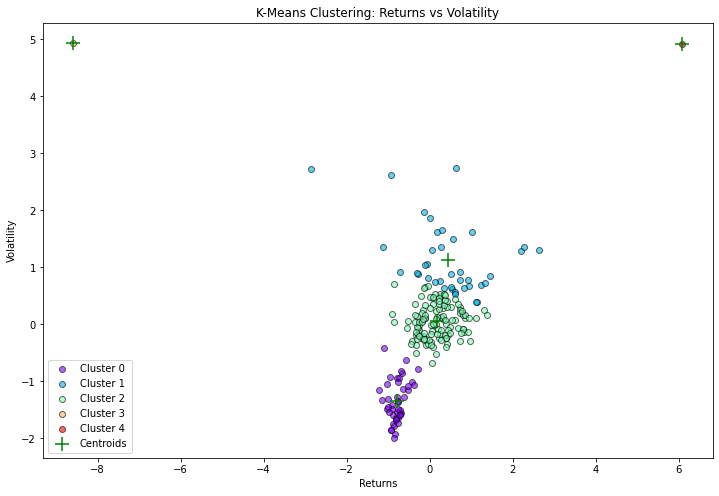

In [106]:
# Crear un scatter plot con Returns en el eje X y Volatility en el eje Y
plt.figure(figsize=(12, 8))

# Obtener los clusters únicos para crear la leyenda
unique_clusters = sorted(set(prediction))

# Asignar colores a cada cluster
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_clusters)))

# Graficar cada cluster por separado para agregar a la leyenda
for cluster, color in zip(unique_clusters, colors):
    cluster_points = df_scaled[prediction == cluster]
    plt.scatter(
        cluster_points['Returns'], 
        cluster_points['Volatility'], 
        label=f'Cluster {cluster}', 
        color=color, 
        alpha=0.6, 
        edgecolor='k'
    )

# Añadir los centroides
centroids = k_means.cluster_centers_
plt.scatter(
    centroids[:, 0], 
    centroids[:, 1], 
    c='green', 
    marker='+', 
    s=200, 
    label='Centroids'
)

# Etiquetas y título
plt.title('K-Means Clustering: Returns vs Volatility')
plt.xlabel('Returns')
plt.ylabel('Volatility')
plt.legend()
plt.show()

In [107]:
# Return the series
clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series_all = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]
clustered_series[:7]

AADR    2
AAXJ    2
ACWI    2
ACWX    2
AGNG    2
AGZD    0
AIA     2
dtype: int32

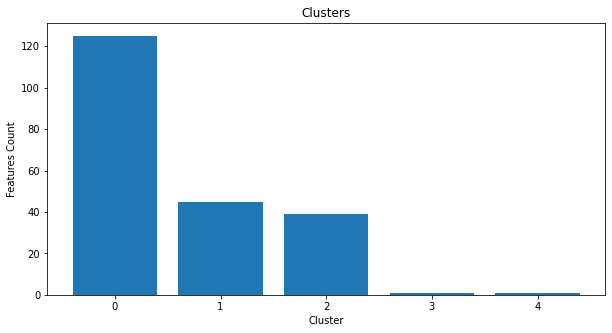

In [108]:
# View number by cluster
plt.figure(figsize=(10, 5))
plt.bar(range(len(clustered_series.value_counts())), clustered_series.value_counts())
plt.title("Clusters")
plt.xlabel("Cluster")
plt.ylabel("Features Count")
plt.show()

In [109]:
# Remove Items if Preferred
clusters_clean = clustered_series[clustered_series < 3]
print("Feature Number Previous: ", len(clustered_series))
print("Feature Number Current: ", len(clusters_clean))

Feature Number Previous:  211
Feature Number Current:  209


### Calculate Cointegration

Cointegration: looking for two 

Statistical Arbitraje

In [110]:
# Calculate cointegration
def calculate_cointegration(series_1, series_2):
    coint_flag = 0
    coint_res = coint(series_1, series_2)
    coint_t = coint_res[0]
    p_value = coint_res[1]
    critical_value = coint_res[2][1]
    model = sm.OLS(series_1, series_2).fit()
    hedge_ratio = model.params[0]
    coint_flag = 1 if p_value < 0.05 and coint_t < critical_value else 0
    return coint_flag, hedge_ratio, p_value

In [111]:
# Loop through and calculate cointegrated pairs
# Allow 10 - 30 mins for calculation 
tested_pairs = []
cointegrated_pairs = []

if not load_coint_pairs:
    for base_asset in clusters_clean.index:
        base_label = clusters_clean[base_asset]
        
        for compare_asset in clusters_clean.index:
            compare_label = clusters_clean[compare_asset]
            
            test_pair = base_asset + compare_asset
            test_pair = ''.join(sorted(test_pair))
            is_tested = test_pair in tested_pairs
            tested_pairs.append(test_pair)
            
            if compare_asset != base_asset and base_label == compare_label and not is_tested:
                
                series_1 = data[base_asset].values.astype(float)
                series_2 = data[compare_asset].values.astype(float)
                coint_flag, hedge_ratio, p_value = calculate_cointegration(series_1, series_2)
                if coint_flag == 1:
                    cointegrated_pairs.append({"base_asset": base_asset, 
                                               "compare_asset": compare_asset, 
                                               "label": base_label,
                                               "hedge_ratio": hedge_ratio,
                                               "p_value": p_value})
                    
    df_coint = pd.DataFrame(cointegrated_pairs).sort_values(by="label")
    df_coint.to_csv(file_name_coint)

In [112]:
# Load Cointegrated Pairs
df_coint = pd.read_csv(file_name_coint).iloc[:, 1:]
df_coint.head()

,base_asset,compare_asset,label,hedge_ratio,p_value
0,AAXJ,AIA,0,1.106911,0.026422
1,FTXH,RDVY,0,0.588362,0.025508
2,FTXH,QQXT,0,0.333795,0.004174
3,FTXH,QQQE,0,0.360429,0.013481
4,FTXH,QQEW,0,0.258260,0.014302


### TSNE Plot for Visualization

In [113]:
# Get unique list of cointegrated assets
coint_assets = [df_coint["base_asset"].values]
coint_assets.append(df_coint["compare_asset"].values)
coint_unique_assets = np.unique(coint_assets)
coint_unique_assets[:5]

array(['AAXJ', 'ACWI', 'ACWX', 'AGNG', 'AGZD'], dtype=object)

In [114]:
# Get TSNE only returns and volatility
df_TSNE = df_scaled.copy()
df_TSNE = df_TSNE[df_TSNE.index.isin(coint_unique_assets)]
df_TSNE.head()

,Returns,Volatility
AAXJ,-0.185772,0.061477
ACWI,0.392520,-0.231500
ACWX,-0.162929,-0.230138
AGNG,0.230755,-0.231763
AGZD,-0.760581,-1.648264


In [115]:
# Compute TSNE
X_tsne = TSNE(learning_rate=30, perplexity=5, random_state=42, n_jobs=-1).fit_transform(df_TSNE)
X_tsne[:5]

array([[-25.641487 ,  -4.4561887],
       [ 33.779327 ,   5.4743323],
       [ -2.5184472,  17.48332  ],
       [ 26.759703 ,   7.1730757],
       [-19.12145  ,  39.92632  ]], dtype=float32)

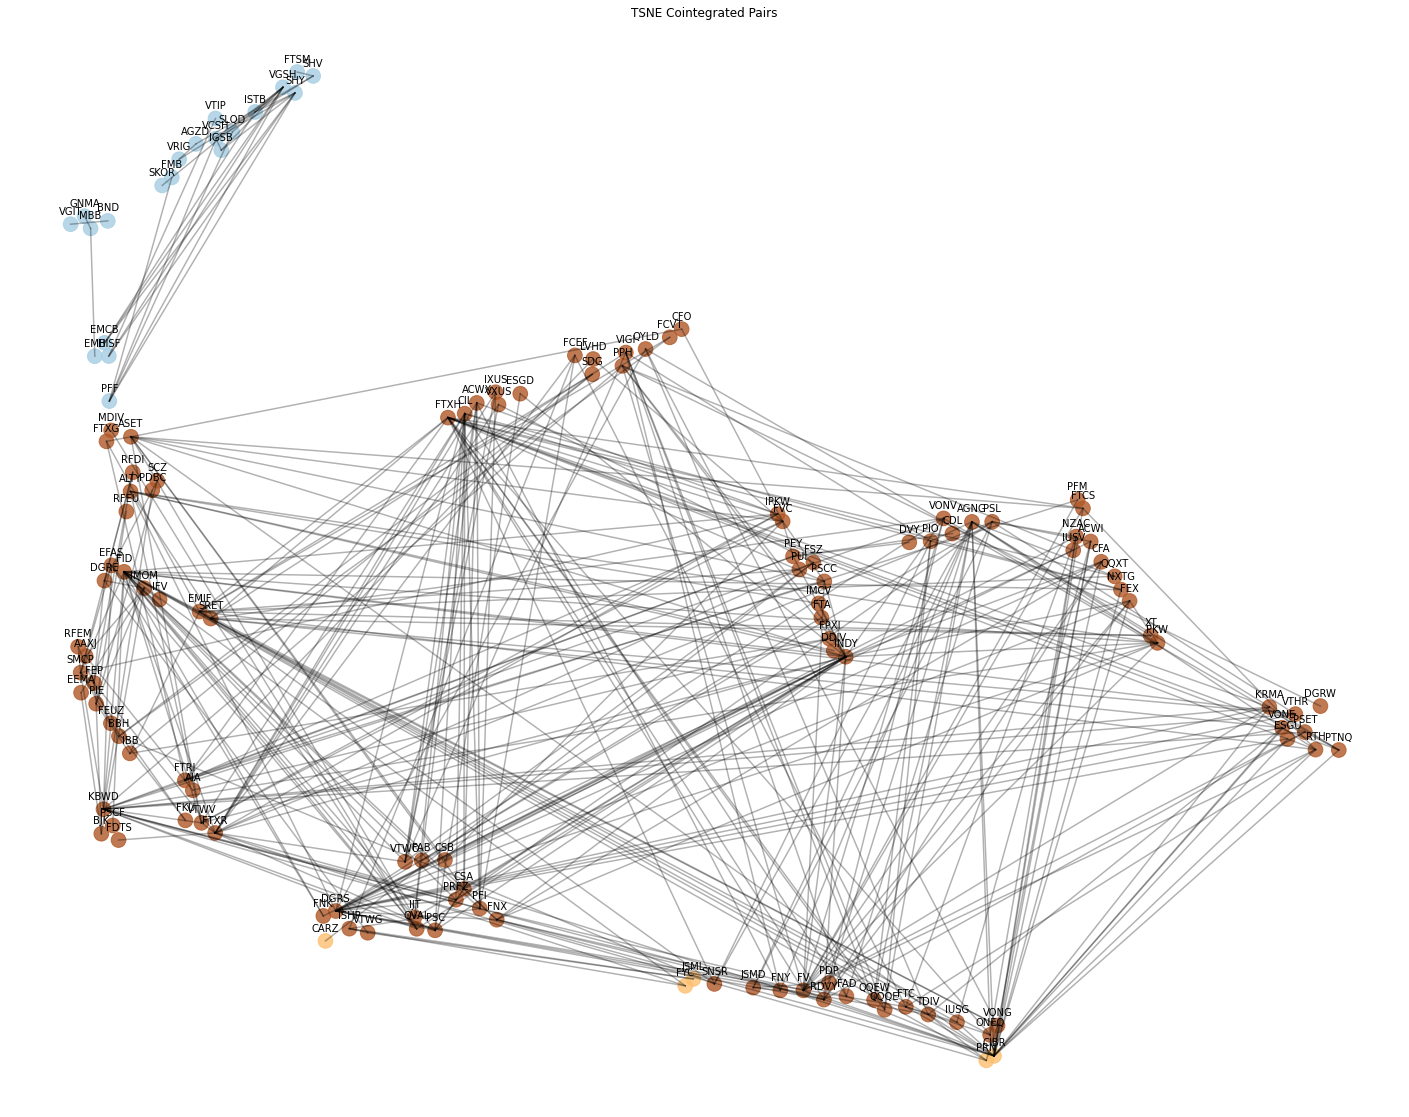

In [116]:
# Preview TSNE
in_pairs_series = clustered_series.loc[coint_unique_assets]
plt.figure(1, figsize=(25, 20))
plt.clf()
plt.axis('off')
for index, pair in df_coint.iterrows():
    ticker1 = pair[0]
    loc1 = df_TSNE.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]
    ticker2 = pair[0]
    loc2 = df_TSNE.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]
    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3)
    
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=215, alpha=0.8, c=in_pairs_series.values, cmap=cm.Paired)
plt.title('TSNE Cointegrated Pairs')

# Show TSNE Plot
for x, y, name in zip(X_tsne[:, 0], X_tsne[:, 1], df_TSNE.index):
    label = name
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(0,10), ha="center")
plt.show()

### Review a Pair

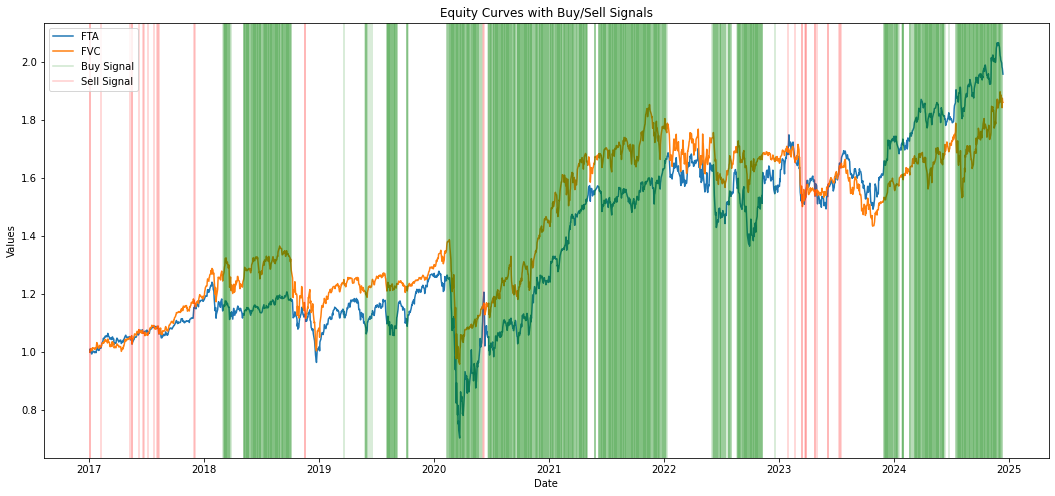

In [121]:
data.index = pd.to_datetime(data.index)

# Plot price comparison for any given assets
asset_1 = "FTA"
asset_2 = "FVC"

# Normalizar los valores de los activos
asset_1_values = data[asset_1].values / data[asset_1].iloc[0].item()
asset_2_values = data[asset_2].values / data[asset_2].iloc[0].item()

# Calcular la diferencia entre las dos curvas normalizadas
diff = asset_1_values - asset_2_values

# Umbral para separación significativa
separation_threshold = diff.std()

# Identificar señales de compra y venta
buy_signals = np.where(np.abs(diff) > separation_threshold)[0]  # Separación significativa en cualquier dirección
sell_signals = np.where(np.sign(diff[:-1]) != np.sign(diff[1:]))[0]  # Cambios de signo en diff

# Graficar las curvas con líneas verticales en los puntos de interés
fig, ax = plt.subplots(figsize=(18, 8))

# Graficar las curvas normalizadas
ax.plot(data.index, asset_1_values, label=asset_1)
ax.plot(data.index, asset_2_values, label=asset_2)

# Añadir líneas verticales en los puntos de separación significativa
for idx in buy_signals:
    ax.axvline(x=data.index[idx], color='green', linestyle='-', alpha=0.2, label='Buy Signal' if idx == buy_signals[0] else None)

# Añadir líneas verticales en los puntos de convergencia
for idx in sell_signals:
    ax.axvline(x=data.index[idx], color='red', linestyle='-', alpha=0.2, label='Sell Signal' if idx == sell_signals[0] else None)

# Configurar título, etiquetas y leyenda
ax.set_title("Equity Curves with Buy/Sell Signals")
ax.set_xlabel("Date")
ax.set_ylabel("Values")
ax.legend()
plt.show()

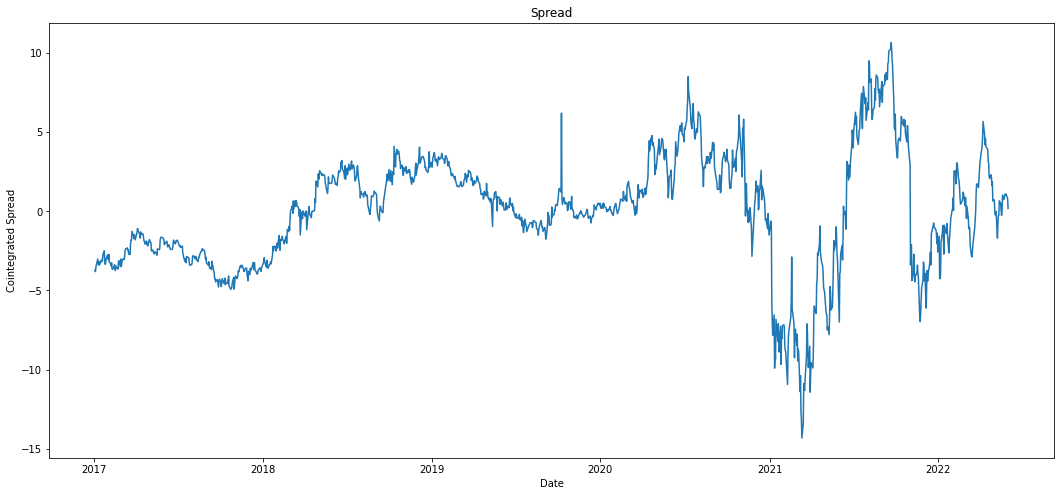

In [33]:
# Plot the Spread
series_1 = data[asset_1].values.astype(float)
series_2 = data[asset_2].values.astype(float)
coint_flag, hedge_ratio = calculate_cointegration(series_1, series_2)
spread = series_1 - (hedge_ratio * series_2)
fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(data.index, spread)
ax.set_title("Spread")
ax.set_xlabel("Date")
ax.set_ylabel("Cointegrated Spread")
plt.show()

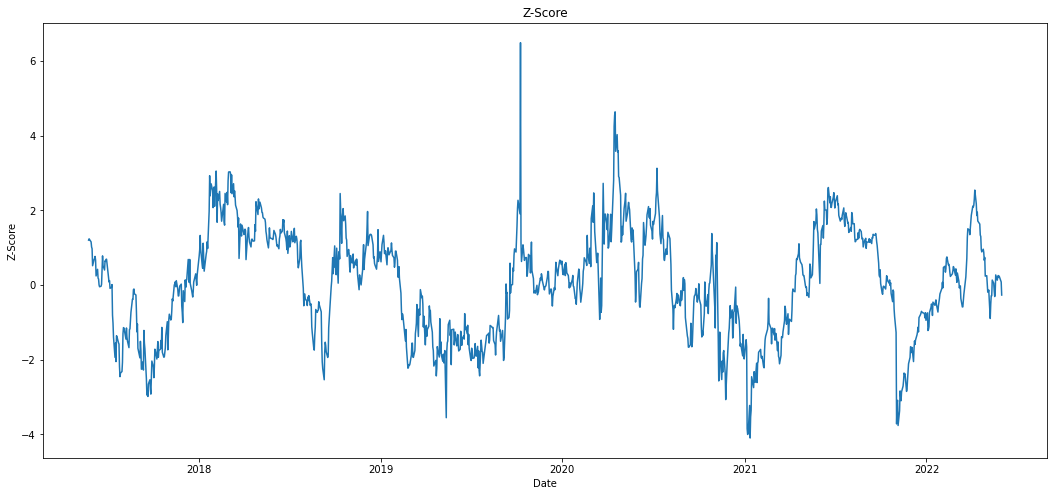

In [35]:
# Plot the ZScore
window = 100
spread_series = pd.Series(spread)
mean = spread_series.rolling(center=False, window=window).mean()
std = spread_series.rolling(center=False, window=window).std()
x = spread_series.rolling(center=False, window=1).mean()
z_score = (x - mean) / std
fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(data.index, z_score)
ax.set_title("Z-Score")
ax.set_xlabel("Date")
ax.set_ylabel("Z-Score")
plt.show()

### Save Data

In [ ]:
# Save Data
capped = []
for z in z_score:
    z = 6 if z > 6 else z
    z = -6 if z <-6 else z
    capped.append(z)
df_save = data[[asset_1, asset_2]].copy()
df_save["Spread"] = spread
df_save["ZScore"] = capped
df_save.dropna(inplace=True)
df_save.columns = ["Asset1", "Asset2", "Spread", "ZScore"]
df_save.to_csv("data/pair_trade.csv")
df_save.head()

,Asset1,Asset2,Spread,ZScore
Date,,,,
2017-05-25,53.630291,52.344387,-1.673399,1.204262
2017-05-26,53.620483,52.295151,-1.631186,1.238759
2017-05-30,53.532246,52.255764,-1.677811,1.156256
2017-05-31,53.571461,52.373917,-1.763428,1.019630
2017-06-01,54.061672,52.856403,-1.782981,0.973343


### Conclusion

When sifting through heavy amounts of price data, it can be tricky to find potentially great pairs to trade quickly. Equally, having pairs which match likeness in terms of price behaviour including volatility, might be advantageous and ensure better risk management.

By clustering using K-Means, we have been able to quickly identify a list of trading pairs which resemble a likeness in respect to returns versus volatility. Helping to refine our conintegrated statistical arbitrage trading strategy even further.

With your new found skills, you could even automate the hunt for potentially great trading opportunities.

### References and Useful Material

Heavily influenced by *Igor Radovanovic* - Last Updated 29 Jul 2021
https://algotrading101.com/learn/cluster-analysis-guide/

*Shaun McDonogh* - Statistical Arbitrage Course
https://www.udemy.com/course/statistical-arbitrage-bot-build-in-crypto-with-python-a-z/